In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tkinter import *
from PIL import Image, ImageTk

print('Required version:')
print('     numpy  1.24.4')
print('     cv2 4.8.0')
print('     matplotlib 3.7.1')

print('Current version:')
print('     numpy ', np.__version__)
print('     cv2', cv.__version__)
print('     matplotlib', plt.matplotlib.__version__)

Required version:
     numpy  1.24.4
     cv2 4.8.0
     matplotlib 3.7.1
Current version:
     numpy  1.24.4
     cv2 4.8.0
     matplotlib 3.7.1


In [2]:
def modify_img():
    # clear the canvas
    cas.itemconfig(img_canvas, image=img_im2_tk)
    cas.itemconfig(text_canvas, text="Click 4 points on im2")


# build a window object
loc = Tk()

#box for points
nodes = []

#size of the window
loc.geometry("850x800")
loc.title("part3")
cas = Canvas(loc, width=920, height=720, bg='white', )
cas.pack()

img_im1 = Image.open('./img/im01.jpg')
img_im2 = Image.open('./img/im02.jpg')
img_im1_tk = ImageTk.PhotoImage(img_im1)
img_im2_tk = ImageTk.PhotoImage(img_im2)

img_canvas = cas.create_image(0, 0, image=img_im1_tk, anchor=NW)
cas.config(scrollregion=cas.bbox(ALL))
text_canvas = cas.create_text(200, 500, text="Click 4 points on im1", font=("Arial", 20))
cas.create_text(180, 550, text="Position of points:", font=("Arial", 20))

e2c = lambda et, cas: (cas.canvasx(et.x), cas.canvasy(et.y))


def print_pos(e):
    px, py = e2c(e, cas)
    point_c = [e.y, e.x, py, px]
    nodes.append(point_c)
    index = len(nodes)
    cas.create_text(240 + index * 62, 550, text=f"P{index}:(%d,%d)," % (e.y, e.x), font=("Arial", 10))
    print(f"Point {index}: ({e.y}, {e.x}) - ({py}, {px})")


cas.bind("<ButtonPress-1>", print_pos)

button = Button(loc, text='Next img', command=modify_img)
button.place(x=700, y=740)

loc.mainloop()

Point 1: (227, 322) - (224.0, 319.0)
Point 2: (238, 629) - (235.0, 626.0)
Point 3: (464, 309) - (461.0, 306.0)
Point 4: (472, 625) - (469.0, 622.0)
Point 5: (211, 26) - (208.0, 23.0)
Point 6: (265, 348) - (262.0, 345.0)
Point 7: (453, 10) - (450.0, 7.0)
Point 8: (470, 351) - (467.0, 348.0)


In [3]:
# homography computing
def homography(points):
    if len(points) < 8:
        raise ValueError("At least 8 points (4 point correspondences) are required.")

    ma = np.zeros([8, 9])

    for i in range(0, 4):
        h1_x, h1_y, h2_x, h2_y = points[i][2], points[i][3], points[i + 4][2], points[i + 4][3]

        ma[2 * i][:] = [h1_x, h1_y, 1, 0, 0, 0, -h2_x * h1_x, -h2_x * h1_y, -h2_x]
        ma[2 * i + 1][:] = [0, 0, 0, h1_x, h1_y, 1, -h2_y * h1_x, -h2_y * h1_y, -h2_y]
    if not (len(ma.shape) == 2):
        raise ValueError('ma is not a 2D matrix')
    _, _, vt = np.linalg.svd(ma)
    res = vt[-1].reshape(3, 3)
    res = res / res[2, 2]
    # print(res)
    return res


def size_shape(H, h1):
    if not h1.any():
        raise ValueError("h1 is None")
    if len(h1.shape) == 2:
        [r_val, c_val] = h1.shape
        cc = 1
    else:
        [r_val, c_val, cc] = h1.shape

    [r_val, c_val, cc] = h1.shape
    lt, rt, lb, rb = np.array([[0, 0, 1]]), np.array([[0, c_val, 1]]), np.array([[r_val, 0, 1]]), np.array(
        [[r_val, c_val, 1]])
    if cc == 1:
        lt = lt.T
        rt = rt.T
        lb = lb.T
        rb = rb.T
    # edge matrix
    edge = np.concatenate((lt, rt, lb, rb), axis=0).T
    if cc == 1:
        edge = edge.T
    e_trans = np.dot(H, edge)
    # normalize
    e_trans = e_trans[0:2, :] / e_trans[2, :]
    e_trans = e_trans

    return np.max(e_trans[0, :]), np.min(e_trans[0, :]), np.max(e_trans[1, :]), np.min(e_trans[1, :])


In [4]:
img1 = cv.imread('./img/im01.jpg', cv.IMREAD_COLOR)
img2 = cv.imread('./img/im02.jpg', cv.IMREAD_COLOR)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

In [5]:
def build_canvas(img1, img2, H_i):
    if not (len(img1.shape) == 3 and len(img2.shape) == 3):
        raise ValueError('im1 or im2 is not a RGB image')

    [r1_val, c1_val, _] = img1.shape
    [_, _, cc] = img2.shape

    [x_max, x_min, y_max, y_min] = size_shape(H_i, img2)
    x_sub = int(np.min([0, x_min]) - 1)
    x_add = int(np.max([0, x_max - r1_val]) + 1)
    y_sub = int(np.min([0, y_min]) - 1)
    y_add = int(np.max([0, y_max - c1_val]) + 1)
    px_sub = np.zeros([-x_sub, c1_val, cc])
    px_add = np.zeros([x_add, c1_val, cc])

    if not (len(px_sub.shape) == 3 and len(px_add.shape) == 3):
        raise ValueError('add_x_minus or add_x_plus is not a RGB image')

    py_sub = np.zeros([-x_sub + r1_val + x_add, -y_sub, cc])
    py_add = np.zeros([-x_sub + r1_val + x_add, y_add, cc])
    # if not (len(py_sub.shape) == 3 and len(py_add.shape) == 3):
    #     raise ValueError('add_y_minus or add_y_plus is not a RGB image')
    cas = np.concatenate((px_sub, img1, px_add), axis=0)
    cas = np.concatenate((py_sub, cas, py_add), axis=1)

    return cas.astype(int), [x_sub, y_sub]


In [6]:
H = homography(nodes)
H_i = np.linalg.inv(H)
cas, compensation = build_canvas(img1, img2, H_i)

In [7]:
def trans_im22im1(comp, H_i, cas, im2):
    if not (len(cas.shape) == 3 and len(im2.shape) == 3):
        raise ValueError('canvas or im2 is not a RGB image')
    w = 0.618
    sps = 2
    [r_val, c_val, _] = im2.shape
    if not (len(comp) == 2):
        raise ValueError('compensation is not a 2D vector')
    # draw im2 on the canvas
    for i in range(0, r_val * sps):
        for j in range(0, c_val * sps):
            # positon: points of im2 in im1 plane 
            p = np.array([[i / sps, j / sps, 1]]).T
            trans_p = np.dot(H_i, p)

            x1 = int(i / sps)
            x2 = int(round(trans_p[0, 0] / trans_p[2, 0]) - comp[0])
            
            y1 = int(j / sps)
            y2 = int(round(trans_p[1, 0] / trans_p[2, 0]) - comp[1])

            if np.any(cas[x2, y2] > 0):
                cas[x2, y2] = w * cas[x2, y2][:] + (1 - w) * im2[x1, y1][:]
            else:
                cas[x2, y2] = im2[x1, y1][:]

    return cas.astype(int)


# Interpolation process to fill the blank
def interpolation(image, size):
    if not (len(image.shape) == 3):
        raise ValueError('image is not a RGB image')
    [row, col, c] = image.shape
    valid_pixels = image[~np.isnan(image)]  # catch the valid pixels
    default_val = int(np.mean(valid_pixels)) if valid_pixels.size else 0  # cumpute the mean of valid pixels
    for j in range(0, row):
        for k in range(0, col):
            if np.all(np.isnan(image[j, k]) | (image[j, k] == 0)):  # check if NaN or 0
                for n in range(0, c):
                    r_start, r_end = max(j - size, 0), min(j + size + 1, row)
                    c_start, c_end = max(k - size, 0), min(k + size + 1, col)

                    sub_array = image[r_start:r_end, c_start:c_end, n]
                    avg_val = np.nanmean(sub_array)  # use np.nanmean to ignore NaN values

                    if np.isnan(avg_val):  # if NaN，use default value
                        avg_val = default_val

                    image[j, k, n] = int(avg_val)

    return image


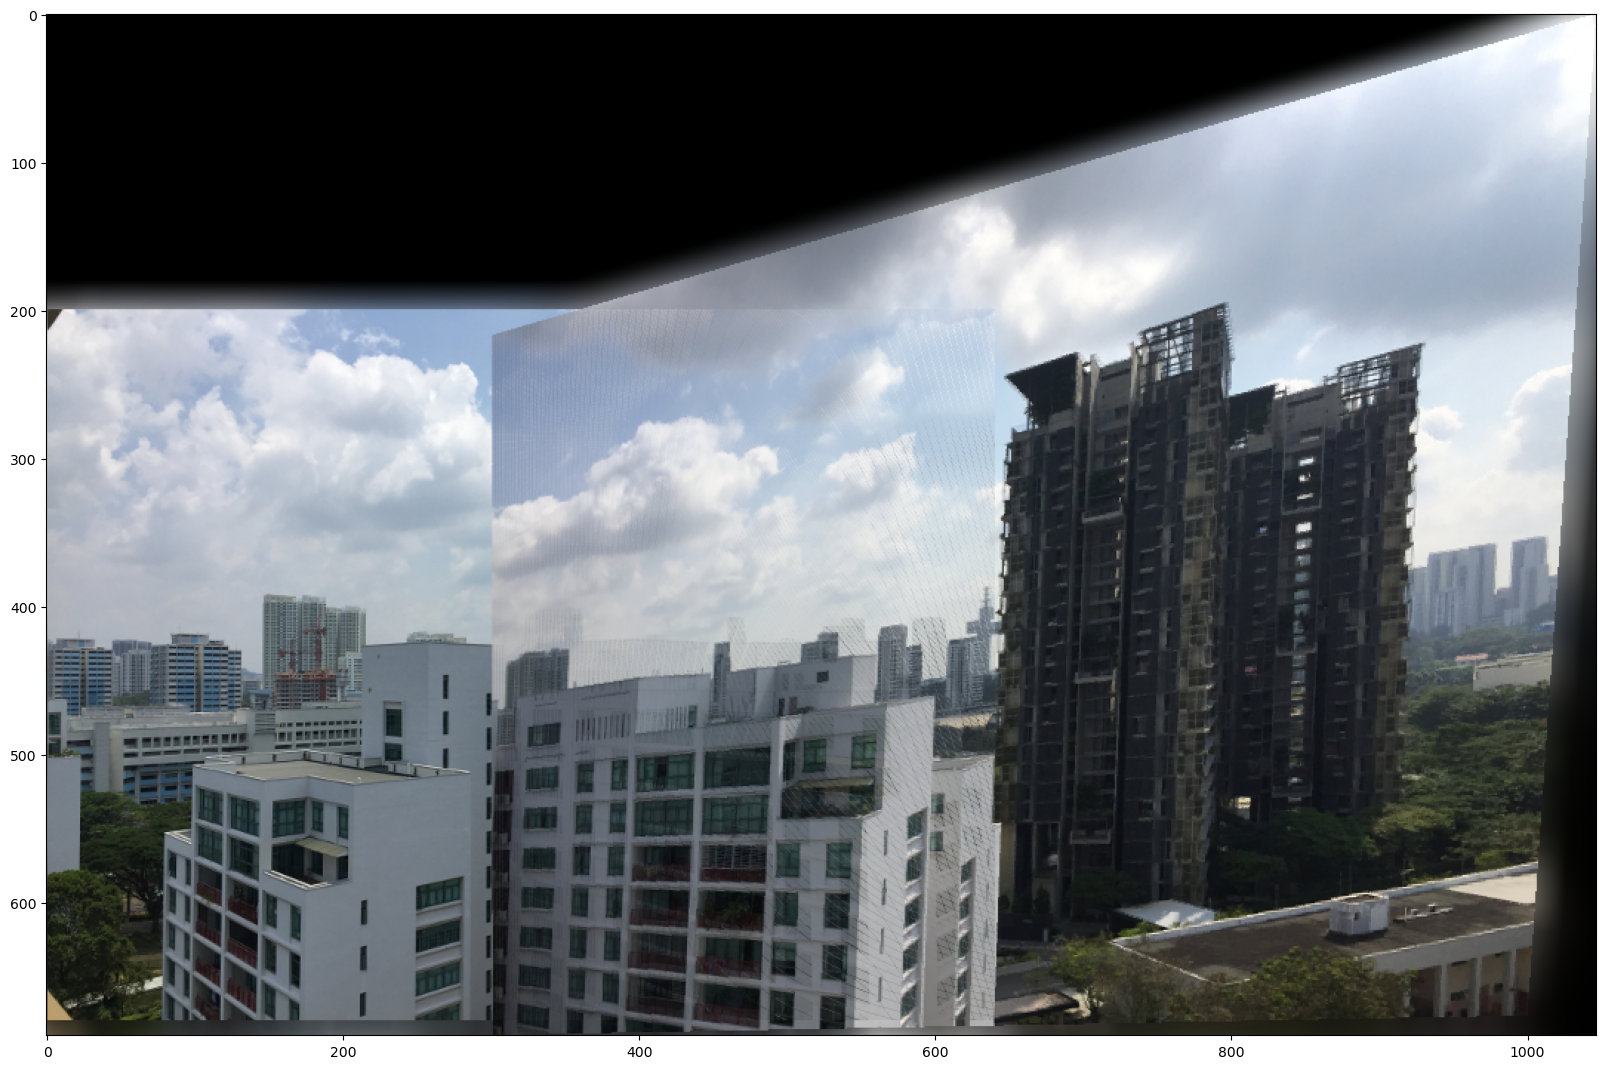

In [8]:
tr = trans_im22im1(compensation, H_i, cas, img2)
tr_inter = interpolation(tr, 19)
plt.figure(figsize=(20, 20))
plt.imshow(tr_inter)

## Because the points we choose in im01 and im02 are not the same point in the reality. There is small error. For instance, there is a point in im01 named p1 and its corresponding point in im2 named p2. The real position of p2 in im01 is (p2x,p2y) and the computed p2 position via homography is (p2x+x_error,p2y+y_error). Therefore, the double edges appear. Actually, due to the distinguishability of image is not ifinity. So the error always exists.